Sheet 1.1: Vanilla RSA
======================

**Author:** Michael Franke



This is a (numpy-based) Python implementation of a vanilla Rational Speech Act model for a reference game.

The same model is also covered in [chapter 1 of problang.org](http://www.problang.org/chapters/01-introduction.html).



## Packages



The \`numpy\` package is used here in order to implement the RSA model using vector and matrix computation.
Additionally, we use the \`seaborn\` package for visualizing the model&rsquo;s predictions.
The input for the \`seaborn\` plots are Data Frames from the \`pandas\` package.
We also might need \`matplotlib\` to produce (render) the plots.
Finally, this notebook uses the \`warnings\` package to suppress all warning messages (not necessarily best practice in general, but acceptable here, as not all warnings are critical and could just distract).



In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Running example



We will use a single running example here.
The reference game in question is show below.

![img](https://github.com/michael-franke/npNLG/blob/main/neural_pragmatic_nlg/pics/02-reference-game.png?raw=1)

There are three objects, all of which could be the speaker&rsquo;s intended referent.
The set of utterances consists of the expressions: &rsquo;blue&rsquo;, &rsquo;green&rsquo;, &rsquo;circle&rsquo; and &rsquo;square&rsquo;.

In python code, we can represent this context as follows:



In [2]:
##################################################
## defining the context
##################################################

object_names    = ['blue_circle', 'green_square', 'blue_square']
utterance_names = ['blue', 'circle', 'green', 'square']

semantic_meaning = np.array(
    # blue circle, green square, blue square
    [[1, 0, 1],  # blue
     [1, 0, 0],  # circle
     [0, 1, 0],  # green
     [0, 1, 1]]  # square,
    )

## Helper functions



Two helper functions will come in handy:
one for normalizing vectors and matrices;
another for computing soft-max.



In [3]:
##################################################
## helper functions
##################################################

def softmax(x, axis=1):
    """
    Softmax function in numpy
    Parameters
    ----------
    x: array
        An array with any dimensionality
    axis: int
        The axis along which to apply the softmax
    Returns
    -------
    array
        Same shape as x
    """
    e_x = np.exp(x - np.max(x, axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)


def normalize(arr, axis=1):
    """
    Normalize arr along axis
    """
    return arr / arr.sum(axis, keepdims=True)

In [4]:
##################################################
## add solutions here for exercise 1.1.1
##################################################
#1.
row_stochastic_matrix = normalize(np.array([[1,2], [3,4]]), axis=1)
column_stochastic_matrix = normalize(np.array([[1,2], [3,4]]), axis=0)
#2.
row_stochastic = softmax(np.array([[1,2],[3,4],[5,6]]), axis=1)
print(row_stochastic)
column_stochastic = softmax(np.array([[1,2],[3,4],[5,6]]), axis=0)
print(column_stochastic)
#3.
print(softmax(np.array([1, 2, 3]), axis=0))
print(normalize(np.array([1, 2, 3]), axis=0))

[[0.26894142 0.73105858]
 [0.26894142 0.73105858]
 [0.26894142 0.73105858]]
[[0.01587624 0.01587624]
 [0.11731043 0.11731043]
 [0.86681333 0.86681333]]
[0.09003057 0.24472847 0.66524096]
[0.16666667 0.33333333 0.5       ]


> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 1.1.1: Apply the helper functions</span></strong>
> 1. Normalize the following matrix to a row-stochastic and a column-stochastic matrix for the matrix: $[[1,2], [3,4]]$.
> 2. Apply softmax to the following matrix to obtain a row-stochastic and a column-stochastic matrix:  $[[1,2], [3,4], [5,6]]$.
> 3. Compute the soft-max and the normalized stochastic vector for the vector $[1,2,3]$. (NB: the definitions do *not* expect vector input, so &#x2026; what do you do?)



## The model and its parameters



The model we want to implement is defined as follows:

\begin{align*}
P_{lit}(s \mid u) & \propto L(u,s) \\
P_S( u \mid s) &= \mathrm{SoftMax}  \left ( \alpha \left ( \log P_{lit}(s \mid u)  - \mathrm{C}(u) \right ) \right ) \\
P_L( s \mid u) & \propto P_{sal}(s) \ P_S( u \mid s)
\end{align*}

Here, $L$ is a *lexicon*, which assigns a truth-value (usually 0 or 1) to each pair of utterance and state.
The sign $\propto$ is to be read as &ldquo;proportional to&rdquo; and implies proper normalization of the to-be-defined (conditional) distributions.
The parameter $\alpha$ is the usual &ldquo;optimality&rdquo; or &ldquo;inverse temperature&rdquo; parameter of the soft-max function.
The cost function $C$ assigns a real number to each utterance, representing the relative effort or dispreference for that utterance.
(NB: Since soft-max is only sensitive to (additive) differences, only differences in cost between utterances matter.)
The salience prior $P_{sal}$ provides a relative weight of accessibility, salience or *a priori* bias for each object.

The model&rsquo;s free parameters are: the optimality parameter $\alpha$, the relative cost $C(u_{\text{ajd}})$ of using an adjective (rather than a noun, where $C(u_{\text{noun}})=0$), and the salience prior $P_{sal}$.

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 1.1.2: Paraphrase the definitions</span></strong>
>
> Provide a short, intuitive and explanatory paraphrase for each of the three conditional probability distributions that define the RSA model above. I.e., formulate a sentence or two for each, so that a person can understand the purpose or gist of the definition. The less technical jargon you use, the better. The more insightful to a novice, the better.

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Solutions for Exercise 1.1.2</span></strong>
>
> &#x2026; add your solution here &#x2026;

1. The interpretation of a literal lisener is represented by a conditional probability of each state given the utterance, which is propotional to the truth values assigned to each pair of utterance and state.
2. The probabilities of utterance choices of a pragmatic speaker are calculated by a soft-max function of the information content of a literal interpretation with given utterance deducted by its relative cost. 
3. The interpretation of the pragmatic lisener is propotional to their prior beliefs and the probabilities of utterance choices of a progmatic speaker in various
states.


In [5]:
##################################################
## model parameters
##################################################

alpha              = 1
cost_adjectives    = 0.1
salience_prior_flt = np.array([1,1,1])     # flat
salience_prior_emp = np.array([71,139,30]) # empirical

## Implementation and visualization



              blue  circle  green  square        object
blue_circle   0.31    0.69   0.00    0.00   blue_circle
green_square  0.00    0.00   0.64    0.36  green_square
blue_square   0.48    0.00   0.00    0.52   blue_square
        blue_circle  green_square  blue_square utterance
blue            0.4           0.0          0.6      blue
circle          1.0           0.0          0.0    circle
green           0.0           1.0          0.0     green
square          0.0           0.4          0.6    square


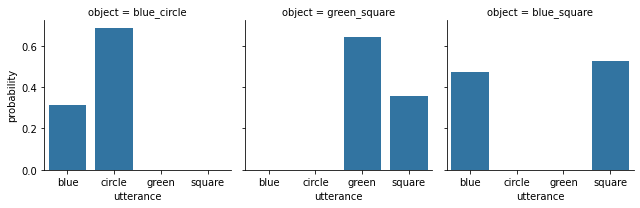

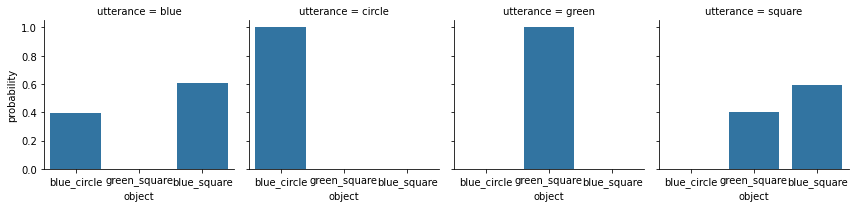

In [6]:
##################################################
## RSA model predictions
##################################################


def RSA(alpha, cost_adjectives, salience_prior):
    """
    predictions of the vanilla RSA model for reference game
    Parameters
    ----------
    alpha: float
        Optimality parameter
    cost_adjectives: float
        Differential cost for production of adjectives
    salience_prior: array
        Prior over objects
    Returns
    -------
    dictionary
        Dictionary with keys 'speaker' and 'listener'
    """
    costs              = np.array([1.0, 0, 1.0, 0]) * cost_adjectives
    literal_listener   = normalize(semantic_meaning)
    util_speaker       = np.log(np.transpose(literal_listener)) - costs
    pragmatic_speaker  = softmax(alpha * util_speaker)
    pragmatic_listener = normalize(np.transpose(pragmatic_speaker) * salience_prior)
    return({'speaker': pragmatic_speaker, 'listener': pragmatic_listener})

RSA_predictions = RSA(alpha, cost_adjectives, salience_prior_flt)

##################################################
## cast model predictions to DataFrames
##################################################

speaker  = pd.DataFrame(data = RSA_predictions['speaker'],
                        index = object_names,
                        columns = utterance_names)
speaker['object'] = speaker.index
print(speaker.round(2))

listener = pd.DataFrame(data    = RSA_predictions['listener'],
                        index   = utterance_names,
                        columns = object_names)
listener['utterance'] = listener.index
print(listener.round(2))

##################################################
## plotting the results
##################################################

speaker_long = speaker.melt(id_vars = "object", var_name = "utterance",
                            value_name = "probability", ignore_index = False)
speaker_plot = sns.FacetGrid(speaker_long, col="object")
speaker_plot.map(sns.barplot, "utterance", "probability")
plt.show()

listener_long = listener.melt(id_vars = "utterance", var_name = "object",
                              value_name = "probability", ignore_index = False)
listener_plot = sns.FacetGrid(listener_long, col="utterance")
listener_plot.map(sns.barplot, "object", "probability")
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 1.1.3: Explore the vanilla RSA model</span></strong>
>
> 0. [for your own sake only; no written answer required] Go through the whole last code block. Try to understand every single line in the function \`RSA<sub>predictions</sub>\`. Ask if anything is unclear. (It is muss less important to understand the details of the subsequent data wrangling and plotting.)
> 1. Explore what happens if you make the speaker more optimal. Does that also affect the listener&rsquo;s inferences? Why? Is that intuitive?
> 2. Add another object to the context, namely a red triangle. Add any relevant utterances, their semantics and costs as well. What do you predict will happen to the model&rsquo;s predictions for the &ldquo;old&rdquo; objects and utterances? Test your predictions (= understanding of the model) and report the results.
> 3. Run the model with different values for the cost parameter \`cost<sub>adjectives</sub>\`. Which effect does this have on the speaker prediction? Which effect does that have on the predictions for listener interpretation? Explain these observation in your own non-technical terms (e.g., for an interested outsider).
> 4. Is there any way to get “blue” to refer to something green? I.e., is it possible (if so: how?; else: why not?) to change the context or model in such a way that $P_{L}(\text{green square} \mid \text{blue}) > 0$, ideally in a way that might also be defensible in that it makes conceptual sense (not just by some technical trick that no reviewer of your work would accept as anything but a hack)?



In [7]:
# Exercise 1.1.3.1

# to make the speaker more optimal, I increase the alpha value to 2
alpha = 2

# run model and print out predictions
RSA_predictions = RSA(alpha, cost_adjectives, salience_prior_flt)
speaker  = pd.DataFrame(data = RSA_predictions['speaker'],
                        index = object_names,
                        columns = utterance_names)
speaker['object'] = speaker.index
print(speaker.round(2))

listener = pd.DataFrame(data    = RSA_predictions['listener'],
                        index   = utterance_names,
                        columns = object_names)
listener['utterance'] = listener.index
print(listener.round(2))

              blue  circle  green  square        object
blue_circle   0.17    0.83   0.00    0.00   blue_circle
green_square  0.00    0.00   0.77    0.23  green_square
blue_square   0.45    0.00   0.00    0.55   blue_square
        blue_circle  green_square  blue_square utterance
blue           0.27           0.0         0.73      blue
circle         1.00           0.0         0.00    circle
green          0.00           1.0         0.00     green
square         0.00           0.3         0.70    square


According to the printed result, after making the speaker more optimal, the listener's inference also becomes more optimal. That is intuitive, because if the lisener presuppose a more rational speaker, they should also make more rational inferences. Besides, since in this model the inferences of listeners are calculated based on the utterance choices of pragmatic speaker, the change in utterance probablities should also influence inferences.

In [10]:
# Exercise 1.1.3.2

# my prediction: adding of a red triangle would not influence the model's 
# predictions on the old objects, since red triangle has no common property
# with previous objects, and therefore would not change the conditional 
# probabilities of the utterances of the old properties given the old objects

# add a red triangle to the context
object_names    = ['blue_circle', 'green_square', 'blue_square', 'red_triangle']
utterance_names = ['blue', 'circle', 'green', 'square', 'red', 'triangle']
semantic_meaning = np.array(
    # blue circle, green square, blue square, red triangle
    [[1, 0, 1, 0],  # blue
     [1, 0, 0, 0],  # circle
     [0, 1, 0, 0],  # green
     [0, 1, 1, 0],  # square
     [0, 0, 0, 1],  # red
     [0, 0, 0, 1]   # trianle
    ])

# modify model parameters
alpha              = 1
cost_adjectives    = 0.1
salience_prior_flt = np.array([1,1,1,1])     # flat

# modify model definition
def RSA(alpha, cost_adjectives, salience_prior):
    """
    predictions of the vanilla RSA model for reference game
    Parameters
    ----------
    alpha: float
        Optimality parameter
    cost_adjectives: float
        Differential cost for production of adjectives
    salience_prior: array
        Prior over objects
    Returns
    -------
    dictionary
        Dictionary with keys 'speaker' and 'listener'
    """
    costs              = np.array([1.0, 0, 1.0, 0, 1.0, 0]) * cost_adjectives
    literal_listener   = normalize(semantic_meaning)
    util_speaker       = np.log(np.transpose(literal_listener)) - costs
    pragmatic_speaker  = softmax(alpha * util_speaker)
    pragmatic_listener = normalize(np.transpose(pragmatic_speaker) * salience_prior)
    return({'speaker': pragmatic_speaker, 'listener': pragmatic_listener})

# run model and print out predictions
RSA_predictions = RSA(alpha, cost_adjectives, salience_prior_flt)
speaker  = pd.DataFrame(data = RSA_predictions['speaker'],
                        index = object_names,
                        columns = utterance_names)
speaker['object'] = speaker.index
print(speaker.round(2))

listener = pd.DataFrame(data    = RSA_predictions['listener'],
                        index   = utterance_names,
                        columns = object_names)
listener['utterance'] = listener.index
print(listener.round(2))

              blue  circle  green  square   red  triangle        object
blue_circle   0.31    0.69   0.00    0.00  0.00      0.00   blue_circle
green_square  0.00    0.00   0.64    0.36  0.00      0.00  green_square
blue_square   0.48    0.00   0.00    0.52  0.00      0.00   blue_square
red_triangle  0.00    0.00   0.00    0.00  0.48      0.52  red_triangle
          blue_circle  green_square  blue_square  red_triangle utterance
blue              0.4           0.0          0.6           0.0      blue
circle            1.0           0.0          0.0           0.0    circle
green             0.0           1.0          0.0           0.0     green
square            0.0           0.4          0.6           0.0    square
red               0.0           0.0          0.0           1.0       red
triangle          0.0           0.0          0.0           1.0  triangle


According to the printed results, the adding of a red triangle indeed did not interfere with the predictions of old objects.

In [11]:
# Exercise 1.1.3.3

# experiment by incrementing the cost of adjectives to 1
cost_adjectives    = 0.1

# run model and print out predictions
RSA_predictions = RSA(alpha, cost_adjectives, salience_prior_flt)
speaker  = pd.DataFrame(data = RSA_predictions['speaker'],
                        index = object_names,
                        columns = utterance_names)
speaker['object'] = speaker.index
print(speaker.round(2))

listener = pd.DataFrame(data    = RSA_predictions['listener'],
                        index   = utterance_names,
                        columns = object_names)
listener['utterance'] = listener.index
print(listener.round(2))

              blue  circle  green  square   red  triangle        object
blue_circle   0.31    0.69   0.00    0.00  0.00      0.00   blue_circle
green_square  0.00    0.00   0.64    0.36  0.00      0.00  green_square
blue_square   0.48    0.00   0.00    0.52  0.00      0.00   blue_square
red_triangle  0.00    0.00   0.00    0.00  0.48      0.52  red_triangle
          blue_circle  green_square  blue_square  red_triangle utterance
blue              0.4           0.0          0.6           0.0      blue
circle            1.0           0.0          0.0           0.0    circle
green             0.0           1.0          0.0           0.0     green
square            0.0           0.4          0.6           0.0    square
red               0.0           0.0          0.0           1.0       red
triangle          0.0           0.0          0.0           1.0  triangle


## References



Frank, M. C., & Goodman, N. D. (2012). Predicting pragmatic reasoning in language games. Science, 336(6084), 998. [http://dx.doi.org/10.1126/science.1218633](http://dx.doi.org/10.1126/science.1218633)

Scontras, G., Tessler, M. H., & Franke, M. (2018). [Probabilistic language understanding: An introduction to the Rational Speech Act framework](http://www.problang.org/).

